In [ ]:
# ─────────────────────────────────────────
# ADR Preprocessing script Deep Learning
# ─────────────────────────────────────────

# Installation of packages
import re
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset
import re

# Hugging Face & datasets
!pip install -q transformers datasets
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments
)

URL     = re.compile(r'http\S+|www\.\S+')
MENTION = re.compile(r'@\w+')

def minimal_clean(text: str) -> str:
    text = str(text)
    text = URL.sub('HTTPURL', text)
    text = MENTION.sub('@USER', text)
    return text.strip()

# Load , Apply preporcessing to datasets and Drop all rows with any NaNs

# CADEC_v2 dataset
cadec = pd.read_csv('/content/drive/My Drive/df_cadec.csv')
cadec['cleaned_text'] = cadec['text'].astype(str).apply(minimal_clean)
df_cadec = cadec.dropna().reset_index(drop=True)

# Reddit
reddit = pd.read_csv('/content/drive/My Drive/adr_dataset_REDDIT.csv')
reddit['cleaned_text'] = reddit['text'].astype(str).apply(minimal_clean)
reddit = reddit.dropna().reset_index(drop=True)

# PsyTAR
file_path = '/content/drive/My Drive/PsyTAR_dataset.xlsx'
PsyTAR['cleaned_text'] = PsyTAR['text'].astype(str).apply(minimal_clean)
PsyTAR = PsyTAR.dropna().reset_index(drop=True)


# Concatenate the 3 datasets and shuffle
train_df = pd.concat([cadec, PsyTAR, reddit], ignore_index=True)
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

train_df['cleaned_text'] = train_df['text'].astype(str).apply(minimal_clean)
train_df = train_df.dropna().reset_index(drop=True)



In [ ]:
# Counts for each class in the datasets
for name, df in {
    'CADEC': cadec,
    'Reddit': reddit,
    'Train': train_df,
    'Pystar': PsyTAR
}.items():
    counts = df['ADR'].value_counts().sort_index()
    print(f"{name} ADR counts:\n{counts}\n")


CADEC ADR counts:
ADR
0     226
1    3322
Name: count, dtype: int64

Reddit ADR counts:
ADR
0.0    960
1.0    336
Name: count, dtype: int64

Train ADR counts:
ADR
0.0    5026
1.0    5826
Name: count, dtype: int64

Pystar ADR counts:
ADR
0    3840
1    2168
Name: count, dtype: int64



In [ ]:
# ───────────────────────────────────────────────────
# RoBERTa Pipeline CADECv2
# ───────────────────────────────────────────────────

# Installation of packages
import pandas as pd
import torch
from torch.nn import CrossEntropyLoss
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset

# 80/20 stratified split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_cadec['cleaned_text'].tolist(),
    df_cadec['ADR'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df_cadec['ADR']
)

# Tokenize with RoBERTa tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=256)
test_encodings  = tokenizer(test_texts,  truncation=True, padding=True, max_length=256)

# Wrap in a Dataset
class TextSentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels    = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k,v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = TextSentimentDataset(train_encodings, train_labels)
test_dataset  = TextSentimentDataset(test_encodings,  test_labels)

# Load RoBERTa model
model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=2
)

# Set up Training Arguments
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    fp16=True,
    per_device_eval_batch_size=8,
    save_strategy="epoch",
    logging_steps=10,
    weight_decay=0.01,
    run_name='roberta-adr',
    learning_rate=2e-5,
    report_to=['none']
)

# Instantiate and train
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

trainer.train()

# === AFTER trainer.train() ===


from google.colab import drive
drive.mount('/content/drive')

# Define path in Drive
import os
drive_output_dir = "/content/drive/My Drive/roberta-adr-results"
os.makedirs(drive_output_dir, exist_ok=True)

# Save the fine tuned model & tokenizer
trainer.save_model(drive_output_dir)
tokenizer.save_pretrained(drive_output_dir)

# Save the fine tuned model & tokenizer
import json
eval_metrics = trainer.evaluate(eval_dataset=test_dataset)
with open(os.path.join(drive_output_dir, "eval_metrics.json"), "w") as f:
    json.dump(eval_metrics, f, indent=2)

print(f" Model, tokenizer and eval metrics saved to {drive_output_dir}")


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Step,Training Loss
10,0.437500
20,0.190400
30,0.289900
40,0.297400
50,0.303900
60,0.277000
70,0.330200
80,0.119200
90,0.135100
100,0.372500


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


✅ Model, tokenizer, and eval metrics saved to /content/drive/My Drive/roberta-adr-results


In [ ]:
# ───────────────────────────────────────────────────
# Metrics
# ───────────────────────────────────────────────────

# Installation of packages
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    classification_report,
    accuracy_score,
    balanced_accuracy_score,
    recall_score
)

model_name = trainer.model.__class__.__name__
print(f"Evaluating model: {model_name}")

# 1) Get model probs and true labels
preds_output = trainer.predict(test_dataset)
logits = preds_output.predictions
y_true = preds_output.label_ids
probs  = torch.softmax(torch.from_numpy(logits), dim=-1).numpy()[:, 1]

# 2) Compute FPR, TPR, thresholds & AUC
fpr, tpr, thresholds = roc_curve(y_true, probs)
auc_score = roc_auc_score(y_true, probs)
print(f"ROC AUC = {auc_score:.4f}")

# 3) Prepare DataFrames
roc_df   = pd.DataFrame({'threshold': thresholds, 'fpr': fpr, 'tpr': tpr})
preds_df = pd.DataFrame({'true_label': y_true, 'probability': probs})

# 4) Apply default threshold (0.5) & evaluate
y_pred_default = (probs >= 0.5).astype(int)

print("\nClassification Report (threshold=0.5):")
print(classification_report(y_true, y_pred_default, digits=4))

# 5) Overall accuracy
acc = accuracy_score(y_true, y_pred_default)
print(f"Accuracy (threshold=0.5):          {acc:.4f}")

# 6) Balanced accuracy
bal_acc = balanced_accuracy_score(y_true, y_pred_default)
print(f"Balanced accuracy (threshold=0.5): {bal_acc:.4f}")

# 7) Specificity = TN / (TN + FP)
specificity = recall_score(y_true, y_pred_default, pos_label=0)
print(f"Specificity (threshold=0.5):      {specificity:.4f}")


ROC AUC = 0.9679

Classification Report (threshold=0.5):
              precision    recall  f1-score   support

           0     0.8462    0.7333    0.7857        45
           1     0.9821    0.9910    0.9865       665

    accuracy                         0.9746       710
   macro avg     0.9141    0.8622    0.8861       710
weighted avg     0.9735    0.9746    0.9738       710

Accuracy (threshold=0.5):          0.9746
Balanced accuracy (threshold=0.5): 0.8622
Specificity (threshold=0.5):      0.7333


In [ ]:
# ───────────────────────────────────────────────────
# Metrics
# ───────────────────────────────────────────────────

# Installation of packages
import torch
import pandas as pd
from sklearn.metrics import (
    roc_auc_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# 1) Get model probs and true labels
preds_output = trainer.predict(test_dataset)
logits = preds_output.predictions
y_true = preds_output.label_ids
probs  = torch.softmax(torch.from_numpy(logits), dim=-1).numpy()[:, 1]

# 2) Apply threshold=0.5 to get hard predictions
y_pred = (probs >= 0.5).astype(int)

# 3) Compute metrics
auc       = roc_auc_score(y_true, probs)
bal_acc   = balanced_accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall    = recall_score(y_true, y_pred, zero_division=0)
f1        = f1_score(y_true, y_pred, zero_division=0)

# 4) Print them out
print(f"ROC AUC:              {auc:.4f}")
print(f"Balanced Accuracy:    {bal_acc:.4f}")
print(f"Precision :{precision:.4f}")
print(f"Recall:   {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


ROC AUC:              0.9679
Balanced Accuracy:    0.8622
Precision :0.9821
Recall:   0.9910
F1 Score: 0.9865


In [ ]:
# ───────────────────────────────────────────────────
# Deberta-v3-small Pipeline CADEC
# ───────────────────────────────────────────────────

# Installation of packages
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset


# 1) 80/20 stratified split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df_cadec['cleaned_text'].tolist(),
    df_cadec['ADR'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df_cadec['ADR']
)

# 2) Tokenize with DeBERTa‑v3‑small tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-small")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=256)
test_encodings  = tokenizer(test_texts,  truncation=True, padding=True, max_length=256)

# 3) Wrap in a Dataset
class TextSentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels    = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k,v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = TextSentimentDataset(train_encodings, train_labels)
test_dataset  = TextSentimentDataset(test_encodings,  test_labels)

# 4) Load model
model = AutoModelForSequenceClassification.from_pretrained(
    "microsoft/deberta-v3-small",
    num_labels=2
)

# 5) Set up training args
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    fp16=True,
    per_device_eval_batch_size=8,
    save_strategy="epoch",
    logging_steps=10,
    weight_decay=0.01,
    run_name='deberta-v3-small-adr',
    report_to=['none']
)

from torch.nn import CrossEntropyLoss
import torch
from transformers import Trainer

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        # class 0 weight = 10, class 1 weight = 1
        weight = torch.tensor([10.0, 1.0], device=logits.device)
        loss_fct = CrossEntropyLoss(weight=weight)
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# 6) Instantiate and train with default loss
trainer = WeightedTrainer(
     model=model,
     args=training_args,
     train_dataset=train_dataset,
     eval_dataset=test_dataset,
 )

trainer.train()

# === AFTER trainer.train() ===

# 1) Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2) Define a path in your Drive
import os
drive_output_dir = "/content/drive/My Drive/cadecdeberta-v3-small-adr-results"
os.makedirs(drive_output_dir, exist_ok=True)

# 3) Save the fine‑tuned model & tokenizer
trainer.save_model(drive_output_dir)
tokenizer.save_pretrained(drive_output_dir)

# 4) Save evaluation metrics to JSON
import json
eval_metrics = trainer.evaluate(eval_dataset=test_dataset)
with open(os.path.join(drive_output_dir, "eval_metrics.json"), "w") as f:
    json.dump(eval_metrics, f, indent=2)

print(f"✅ Model, tokenizer, and eval metrics saved to {drive_output_dir}")


/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.719900
20,0.524200
30,0.756800
40,0.765100
50,0.918600
60,1.211300
70,1.107700
80,0.397900
90,0.284600
100,1.209000


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


✅ Model, tokenizer, and eval metrics saved to /content/drive/My Drive/cadecdeberta-v3-small-adr-results


In [ ]:
# ───────────────────────────────────────────────────
# Metrics
# ───────────────────────────────────────────────────

# Installation of packages
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    classification_report,
    accuracy_score,
    balanced_accuracy_score,
    recall_score
)

model_name = trainer.model.__class__.__name__
print(f"Evaluating model: {model_name}")

# 1) Get model probs and true labels
preds_output = trainer.predict(test_dataset)
logits = preds_output.predictions
y_true = preds_output.label_ids
probs  = torch.softmax(torch.from_numpy(logits), dim=-1).numpy()[:, 1]

# 2) Compute FPR, TPR, thresholds & AUC
fpr, tpr, thresholds = roc_curve(y_true, probs)
auc_score = roc_auc_score(y_true, probs)
print(f"ROC AUC = {auc_score:.4f}")

# 3) Prepare DataFrames
roc_df   = pd.DataFrame({'threshold': thresholds, 'fpr': fpr, 'tpr': tpr})
preds_df = pd.DataFrame({'true_label': y_true, 'probability': probs})

# 4) Apply default threshold (0.5) & evaluate
y_pred_default = (probs >= 0.5).astype(int)

print("\nClassification Report (threshold=0.5):")
print(classification_report(y_true, y_pred_default, digits=4))

# 5) Overall accuracy
acc = accuracy_score(y_true, y_pred_default)
print(f"Accuracy (threshold=0.5):          {acc:.4f}")

# 6) Balanced accuracy
bal_acc = balanced_accuracy_score(y_true, y_pred_default)
print(f"Balanced accuracy (threshold=0.5): {bal_acc:.4f}")

# 7) Specificity = TN / (TN + FP)
specificity = recall_score(y_true, y_pred_default, pos_label=0)
print(f"Specificity (threshold=0.5):      {specificity:.4f}")


ROC AUC = 0.9650

Classification Report (threshold=0.5):
              precision    recall  f1-score   support

           0     0.8235    0.6222    0.7089        45
           1     0.9749    0.9910    0.9828       665

    accuracy                         0.9676       710
   macro avg     0.8992    0.8066    0.8459       710
weighted avg     0.9653    0.9676    0.9655       710

Accuracy (threshold=0.5):          0.9676
Balanced accuracy (threshold=0.5): 0.8066
Specificity (threshold=0.5):      0.6222


In [ ]:
# ───────────────────────────────────────────────────
# Metrics
# ───────────────────────────────────────────────────

# Installation of packages
import torch
import pandas as pd
from sklearn.metrics import (
    roc_auc_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# 1) Get model probs and true labels
preds_output = trainer.predict(test_dataset)
logits = preds_output.predictions
y_true = preds_output.label_ids
probs  = torch.softmax(torch.from_numpy(logits), dim=-1).numpy()[:, 1]

# 2) Apply threshold=0.5 to get hard predictions
y_pred = (probs >= 0.5).astype(int)

# 3) Compute metrics
auc       = roc_auc_score(y_true, probs)
bal_acc   = balanced_accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall    = recall_score(y_true, y_pred, zero_division=0)
f1        = f1_score(y_true, y_pred, zero_division=0)

# 4) Print them out
print(f"ROC AUC:              {auc:.4f}")
print(f"Balanced Accuracy:    {bal_acc:.4f}")
print(f"Precision :{precision:.4f}")
print(f"Recall:   {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


ROC AUC:              0.9650
Balanced Accuracy:    0.8066
Precision :0.9749
Recall:   0.9910
F1 Score: 0.9828


In [ ]:
# ───────────────────────────────────────────────────
# RoBERTa Pipeline Reddit
# ───────────────────────────────────────────────────

# Installation of packages
import pandas as pd
import torch
from torch.nn import CrossEntropyLoss
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset

# 1) 80/20 stratified split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    reddit['cleaned_text'].tolist(),
    reddit['ADR'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=reddit['ADR']
)

# 2) Tokenize with RoBERTa tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=256)
test_encodings  = tokenizer(test_texts,  truncation=True, padding=True, max_length=256)

# 3) Wrap in a Dataset
class TextSentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels    = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k,v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = TextSentimentDataset(train_encodings, train_labels)
test_dataset  = TextSentimentDataset(test_encodings,  test_labels)

# 4) Load RoBERTa model
model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=2
)

# 5) Set up training args
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    fp16=True,
    per_device_eval_batch_size=8,
    save_strategy="epoch",
    logging_steps=10,
    weight_decay=0.01,
    run_name='roberta-adr',
    learning_rate=2e-5,
    report_to=['none']
)

# 6) Instantiate and train
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

trainer.train()

# === AFTER trainer.train() ===

# 1) Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2) Define a path in your Drive
import os
drive_output_dir = "/content/drive/My Drive/redditroberta-adr-results"
os.makedirs(drive_output_dir, exist_ok=True)

# 3) Save the fine‑tuned model & tokenizer
trainer.save_model(drive_output_dir)
tokenizer.save_pretrained(drive_output_dir)

# 4) Save evaluation metrics to JSON
import json
eval_metrics = trainer.evaluate(eval_dataset=test_dataset)
with open(os.path.join(drive_output_dir, "eval_metrics.json"), "w") as f:
    json.dump(eval_metrics, f, indent=2)

print(f"✅ Model, tokenizer, and eval metrics saved to {drive_output_dir}")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Step,Training Loss
10,0.673100
20,0.568300
30,0.726800
40,0.600300
50,0.618400
60,0.521300
70,0.456800
80,0.516500
90,0.496300
100,0.541400


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


✅ Model, tokenizer, and eval metrics saved to /content/drive/My Drive/redditroberta-adr-results


In [ ]:
# ───────────────────────────────────────────────────
# Metrics
# ───────────────────────────────────────────────────

# Installation of packages
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    classification_report,
    accuracy_score,
    balanced_accuracy_score,
    recall_score
)

model_name = trainer.model.__class__.__name__
print(f"Evaluating model: {model_name}")

# 1) Get model probs and true labels
preds_output = trainer.predict(test_dataset)
logits = preds_output.predictions
y_true = preds_output.label_ids
probs  = torch.softmax(torch.from_numpy(logits), dim=-1).numpy()[:, 1]

# 2) Compute FPR, TPR, thresholds & AUC
fpr, tpr, thresholds = roc_curve(y_true, probs)
auc_score = roc_auc_score(y_true, probs)
print(f"ROC AUC = {auc_score:.4f}")

# 3) Prepare DataFrames
roc_df   = pd.DataFrame({'threshold': thresholds, 'fpr': fpr, 'tpr': tpr})
preds_df = pd.DataFrame({'true_label': y_true, 'probability': probs})

# 4) Apply default threshold (0.5) & evaluate
y_pred_default = (probs >= 0.5).astype(int)

print("\nClassification Report (threshold=0.5):")
print(classification_report(y_true, y_pred_default, digits=4))

# 5) Overall accuracy
acc = accuracy_score(y_true, y_pred_default)
print(f"Accuracy (threshold=0.5):          {acc:.4f}")

# 6) Balanced accuracy
bal_acc = balanced_accuracy_score(y_true, y_pred_default)
print(f"Balanced accuracy (threshold=0.5): {bal_acc:.4f}")

# 7) Specificity = TN / (TN + FP)
specificity = recall_score(y_true, y_pred_default, pos_label=0)
print(f"Specificity (threshold=0.5):      {specificity:.4f}")


Evaluating model: RobertaForSequenceClassification


ROC AUC = 0.8937

Classification Report (threshold=0.5):
              precision    recall  f1-score   support

           0     0.9000    0.8906    0.8953       192
           1     0.6957    0.7164    0.7059        67

    accuracy                         0.8456       259
   macro avg     0.7978    0.8035    0.8006       259
weighted avg     0.8471    0.8456    0.8463       259

Accuracy (threshold=0.5):          0.8456
Balanced accuracy (threshold=0.5): 0.8035
Specificity (threshold=0.5):      0.8906


In [ ]:
# ───────────────────────────────────────────────────
# Metrics
# ───────────────────────────────────────────────────

# Installation of packages
import torch
import pandas as pd
from sklearn.metrics import (
    roc_auc_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# 1) Get model probs and true labels
preds_output = trainer.predict(test_dataset)
logits = preds_output.predictions
y_true = preds_output.label_ids
probs  = torch.softmax(torch.from_numpy(logits), dim=-1).numpy()[:, 1]

# 2) Apply threshold=0.5 to get hard predictions
y_pred = (probs >= 0.5).astype(int)

# 3) Compute metrics
auc       = roc_auc_score(y_true, probs)
bal_acc   = balanced_accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall    = recall_score(y_true, y_pred, zero_division=0)
f1        = f1_score(y_true, y_pred, zero_division=0)

# 4) Print them out
print(f"ROC AUC:              {auc:.4f}")
print(f"Balanced Accuracy:    {bal_acc:.4f}")
print(f"Precision :{precision:.4f}")
print(f"Recall:   {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


ROC AUC:              0.8937
Balanced Accuracy:    0.8035
Precision :0.6957
Recall:   0.7164
F1 Score: 0.7059


In [ ]:
# ───────────────────────────────────────────────────
# Deberta-v3-small Pipeline Reddit
# ───────────────────────────────────────────────────

# Installation of packages
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset


# 1) 80/20 stratified split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    reddit['cleaned_text'].tolist(),
    reddit['ADR'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=reddit['ADR']
)

# 2) Tokenize with DeBERTa‑v3‑small tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-small")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=256)
test_encodings  = tokenizer(test_texts,  truncation=True, padding=True, max_length=256)

# 3) Wrap in a Dataset
class TextSentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels    = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k,v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = TextSentimentDataset(train_encodings, train_labels)
test_dataset  = TextSentimentDataset(test_encodings,  test_labels)

# 4) Load model
model = AutoModelForSequenceClassification.from_pretrained(
    "microsoft/deberta-v3-small",
    num_labels=2
)

# 5) Set up training args
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    fp16=True,
    per_device_eval_batch_size=8,
    save_strategy="epoch",
    logging_steps=10,
    weight_decay=0.01,
    run_name='deberta-v3-small-adr',
    report_to=['none']
)

from torch.nn import CrossEntropyLoss
import torch
from transformers import Trainer

class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits
        weight = torch.tensor([1.0, 3.0], device=logits.device)
        loss_fct = CrossEntropyLoss(weight=weight)
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

# 6) Instantiate and train with default loss
trainer = WeightedTrainer(
     model=model,
     args=training_args,
     train_dataset=train_dataset,
     eval_dataset=test_dataset,
 )

trainer.train()

# === AFTER trainer.train() ===

# 1) Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2) Define a path in your Drive
import os
drive_output_dir = "/content/drive/My Drive/redditdeberta-v3-small-adr-results"
os.makedirs(drive_output_dir, exist_ok=True)

# 3) Save the fine‑tuned model & tokenizer
trainer.save_model(drive_output_dir)
tokenizer.save_pretrained(drive_output_dir)

# 4) Save evaluation metrics to JSON
import json
eval_metrics = trainer.evaluate(eval_dataset=test_dataset)
with open(os.path.join(drive_output_dir, "eval_metrics.json"), "w") as f:
    json.dump(eval_metrics, f, indent=2)

print(f"✅ Model, tokenizer, and eval metrics saved to {drive_output_dir}")


/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.684400
20,0.713900
30,0.725000
40,0.679700
50,0.648900
60,0.678900
70,0.603200
80,0.600200
90,0.521900
100,0.709600


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


✅ Model, tokenizer, and eval metrics saved to /content/drive/My Drive/redditdeberta-v3-small-adr-results


In [ ]:
# ───────────────────────────────────────────────────
# Metrics
# ───────────────────────────────────────────────────

# Installation of packages
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    classification_report,
    accuracy_score,
    balanced_accuracy_score,
    recall_score
)

model_name = trainer.model.__class__.__name__
print(f"Evaluating model: {model_name}")

# 1) Get model probs and true labels
preds_output = trainer.predict(test_dataset)
logits = preds_output.predictions
y_true = preds_output.label_ids
probs  = torch.softmax(torch.from_numpy(logits), dim=-1).numpy()[:, 1]

# 2) Compute FPR, TPR, thresholds & AUC
fpr, tpr, thresholds = roc_curve(y_true, probs)
auc_score = roc_auc_score(y_true, probs)
print(f"ROC AUC = {auc_score:.4f}")

# 3) Prepare DataFrames
roc_df   = pd.DataFrame({'threshold': thresholds, 'fpr': fpr, 'tpr': tpr})
preds_df = pd.DataFrame({'true_label': y_true, 'probability': probs})

# 4) Apply default threshold (0.5) & evaluate
y_pred_default = (probs >= 0.5).astype(int)

print("\nClassification Report (threshold=0.5):")
print(classification_report(y_true, y_pred_default, digits=4))

# 5) Overall accuracy
acc = accuracy_score(y_true, y_pred_default)
print(f"Accuracy (threshold=0.5):          {acc:.4f}")

# 6) Balanced accuracy
bal_acc = balanced_accuracy_score(y_true, y_pred_default)
print(f"Balanced accuracy (threshold=0.5): {bal_acc:.4f}")

# 7) Specificity = TN / (TN + FP)
specificity = recall_score(y_true, y_pred_default, pos_label=0)
print(f"Specificity (threshold=0.5):      {specificity:.4f}")


Evaluating model: DebertaV2ForSequenceClassification


ROC AUC = 0.8914

Classification Report (threshold=0.5):
              precision    recall  f1-score   support

           0     0.8901    0.8854    0.8877       192
           1     0.6765    0.6866    0.6815        67

    accuracy                         0.8340       259
   macro avg     0.7833    0.7860    0.7846       259
weighted avg     0.8348    0.8340    0.8344       259

Accuracy (threshold=0.5):          0.8340
Balanced accuracy (threshold=0.5): 0.7860
Specificity (threshold=0.5):      0.8854


In [ ]:
# ───────────────────────────────────────────────────
# Metrics
# ───────────────────────────────────────────────────

# Installation of packages
import torch
import pandas as pd
from sklearn.metrics import (
    roc_auc_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# 1) Get model probs and true labels
preds_output = trainer.predict(test_dataset)
logits = preds_output.predictions
y_true = preds_output.label_ids
probs  = torch.softmax(torch.from_numpy(logits), dim=-1).numpy()[:, 1]

# 2) Apply threshold=0.5 to get hard predictions
y_pred = (probs >= 0.5).astype(int)

# 3) Compute metrics
auc       = roc_auc_score(y_true, probs)
bal_acc   = balanced_accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall    = recall_score(y_true, y_pred, zero_division=0)
f1        = f1_score(y_true, y_pred, zero_division=0)

# 4) Print them out
print(f"ROC AUC:              {auc:.4f}")
print(f"Balanced Accuracy:    {bal_acc:.4f}")
print(f"Precision :{precision:.4f}")
print(f"Recall:   {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


ROC AUC:              0.8914
Balanced Accuracy:    0.7860
Precision :0.6765
Recall:   0.6866
F1 Score: 0.6815


In [ ]:
# ───────────────────────────────────────────────────
# RoBERTa Pipeline PsyTAR
# ───────────────────────────────────────────────────

# Installation of packages
import pandas as pd
import torch
from torch.nn import CrossEntropyLoss
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset

# 1) 80/20 stratified split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    PsyTAR['cleaned_text'].tolist(),
    PsyTAR['ADR'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=PsyTAR['ADR']
)

# 2) Tokenize with RoBERTa tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=256)
test_encodings  = tokenizer(test_texts,  truncation=True, padding=True, max_length=256)

# 3) Wrap in a Dataset
class TextSentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels    = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k,v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = TextSentimentDataset(train_encodings, train_labels)
test_dataset  = TextSentimentDataset(test_encodings,  test_labels)

# 4) Load RoBERTa model
model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=2
)

# 5) Set up training args
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    fp16=True,
    per_device_eval_batch_size=8,
    save_strategy="epoch",
    logging_steps=10,
    weight_decay=0.01,
    run_name='roberta-adr',
    learning_rate=2e-5,
    report_to=['none']
)

# 6) Instantiate and train
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

trainer.train()

# === AFTER trainer.train() ===

# 1) Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2) Define a path in your Drive
import os
drive_output_dir = "/content/drive/My Drive/Pystarroberta-adr-results"
os.makedirs(drive_output_dir, exist_ok=True)

# 3) Save the fine‑tuned model & tokenizer
trainer.save_model(drive_output_dir)
tokenizer.save_pretrained(drive_output_dir)

# 4) Save evaluation metrics to JSON
import json
eval_metrics = trainer.evaluate(eval_dataset=test_dataset)
with open(os.path.join(drive_output_dir, "eval_metrics.json"), "w") as f:
    json.dump(eval_metrics, f, indent=2)

print(f"✅ Model, tokenizer, and eval metrics saved to {drive_output_dir}")


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Step,Training Loss
10,0.716100
20,0.675600
30,0.597900
40,0.593600
50,0.529300
60,0.457400
70,0.392600
80,0.388800
90,0.334100
100,0.493000


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


✅ Model, tokenizer, and eval metrics saved to /content/drive/My Drive/redditroberta-adr-results


In [ ]:
# ───────────────────────────────────────────────────
# Metrics
# ───────────────────────────────────────────────────

# Installation of packages
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    classification_report,
    accuracy_score,
    balanced_accuracy_score,
    recall_score
)

model_name = trainer.model.__class__.__name__
print(f"Evaluating model: {model_name}")

# 1) Get model probs and true labels
preds_output = trainer.predict(test_dataset)
logits = preds_output.predictions
y_true = preds_output.label_ids
probs  = torch.softmax(torch.from_numpy(logits), dim=-1).numpy()[:, 1]

# 2) Compute FPR, TPR, thresholds & AUC
fpr, tpr, thresholds = roc_curve(y_true, probs)
auc_score = roc_auc_score(y_true, probs)
print(f"ROC AUC = {auc_score:.4f}")

# 3) Prepare DataFrames
roc_df   = pd.DataFrame({'threshold': thresholds, 'fpr': fpr, 'tpr': tpr})
preds_df = pd.DataFrame({'true_label': y_true, 'probability': probs})

# 4) Apply default threshold (0.5) & evaluate
y_pred_default = (probs >= 0.5).astype(int)

print("\nClassification Report (threshold=0.5):")
print(classification_report(y_true, y_pred_default, digits=4))

# 5) Overall accuracy
acc = accuracy_score(y_true, y_pred_default)
print(f"Accuracy (threshold=0.5):          {acc:.4f}")

# 6) Balanced accuracy
bal_acc = balanced_accuracy_score(y_true, y_pred_default)
print(f"Balanced accuracy (threshold=0.5): {bal_acc:.4f}")

# 7) Specificity = TN / (TN + FP)
specificity = recall_score(y_true, y_pred_default, pos_label=0)
print(f"Specificity (threshold=0.5):      {specificity:.4f}")


Evaluating model: RobertaForSequenceClassification


ROC AUC = 0.9530

Classification Report (threshold=0.5):
              precision    recall  f1-score   support

           0     0.9153    0.9010    0.9081       768
           1     0.8296    0.8525    0.8409       434

    accuracy                         0.8835      1202
   macro avg     0.8725    0.8768    0.8745      1202
weighted avg     0.8844    0.8835    0.8839      1202

Accuracy (threshold=0.5):          0.8835
Balanced accuracy (threshold=0.5): 0.8768
Specificity (threshold=0.5):      0.9010


In [ ]:
# ───────────────────────────────────────────────────
# Metrics
# ───────────────────────────────────────────────────

# Installation of packages
import torch
import pandas as pd
from sklearn.metrics import (
    roc_auc_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# 1) Get model probs and true labels
preds_output = trainer.predict(test_dataset)
logits = preds_output.predictions
y_true = preds_output.label_ids
probs  = torch.softmax(torch.from_numpy(logits), dim=-1).numpy()[:, 1]

# 2) Apply threshold=0.5 to get hard predictions
y_pred = (probs >= 0.5).astype(int)

# 3) Compute metrics
auc       = roc_auc_score(y_true, probs)
bal_acc   = balanced_accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall    = recall_score(y_true, y_pred, zero_division=0)
f1        = f1_score(y_true, y_pred, zero_division=0)

# 4) Print them out
print(f"ROC AUC:              {auc:.4f}")
print(f"Balanced Accuracy:    {bal_acc:.4f}")
print(f"Precision :{precision:.4f}")
print(f"Recall:   {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


ROC AUC:              0.9530
Balanced Accuracy:    0.8768
Precision :0.8296
Recall:   0.8525
F1 Score: 0.8409


In [ ]:
# ───────────────────────────────────────────────────
# Deberta-v3-small Pipeline PsyTAR
# ───────────────────────────────────────────────────

import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset


# 1) 80/20 stratified split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    PsyTAR['cleaned_text'].tolist(),
    PsyTAR['ADR'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=PsyTAR['ADR']
)

# 2) Tokenize with DeBERTa‑v3‑small tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-small")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=256)
test_encodings  = tokenizer(test_texts,  truncation=True, padding=True, max_length=256)

# 3) Wrap in a Dataset
class TextSentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels    = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k,v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = TextSentimentDataset(train_encodings, train_labels)
test_dataset  = TextSentimentDataset(test_encodings,  test_labels)

# 4) Load model
model = AutoModelForSequenceClassification.from_pretrained(
    "microsoft/deberta-v3-small",
    num_labels=2
)

# 5) Set up training args
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    fp16=True,
    per_device_eval_batch_size=8,
    save_strategy="epoch",
    logging_steps=10,
    weight_decay=0.01,
    run_name='deberta-v3-small-adr',
    report_to=['none']
)

# 6) Instantiate and train with default loss
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

trainer.train()

# === AFTER trainer.train() ===

# 1) Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2) Define a path in your Drive
import os
drive_output_dir = "/content/drive/My Drive/Pystardeberta-v3-small-adr-results"
os.makedirs(drive_output_dir, exist_ok=True)

# 3) Save the fine‑tuned model & tokenizer
trainer.save_model(drive_output_dir)
tokenizer.save_pretrained(drive_output_dir)

# 4) Save evaluation metrics to JSON
import json
eval_metrics = trainer.evaluate(eval_dataset=test_dataset)
with open(os.path.join(drive_output_dir, "eval_metrics.json"), "w") as f:
    json.dump(eval_metrics, f, indent=2)

print(f"✅ Model, tokenizer, and eval metrics saved to {drive_output_dir}")


/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.697600
20,0.648600
30,0.529200
40,0.515200
50,0.437300
60,0.362300
70,0.380800
80,0.390700
90,0.330600
100,0.366400


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


✅ Model, tokenizer, and eval metrics saved to /content/drive/My Drive/Pystardeberta-v3-small-adr-results


In [ ]:
# ───────────────────────────────────────────────────
# Metrics
# ───────────────────────────────────────────────────

# Installation of packages
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    classification_report,
    accuracy_score,
    balanced_accuracy_score,
    recall_score
)

model_name = trainer.model.__class__.__name__
print(f"Evaluating model: {model_name}")

# 1) Get model probs and true labels
preds_output = trainer.predict(test_dataset)
logits = preds_output.predictions
y_true = preds_output.label_ids
probs  = torch.softmax(torch.from_numpy(logits), dim=-1).numpy()[:, 1]

# 2) Compute FPR, TPR, thresholds & AUC
fpr, tpr, thresholds = roc_curve(y_true, probs)
auc_score = roc_auc_score(y_true, probs)
print(f"ROC AUC = {auc_score:.4f}")

# 3) Prepare DataFrames
roc_df   = pd.DataFrame({'threshold': thresholds, 'fpr': fpr, 'tpr': tpr})
preds_df = pd.DataFrame({'true_label': y_true, 'probability': probs})

# 4) Apply default threshold (0.5) & evaluate
y_pred_default = (probs >= 0.5).astype(int)

print("\nClassification Report (threshold=0.5):")
print(classification_report(y_true, y_pred_default, digits=4))

# 5) Overall accuracy
acc = accuracy_score(y_true, y_pred_default)
print(f"Accuracy (threshold=0.5):          {acc:.4f}")

# 6) Balanced accuracy
bal_acc = balanced_accuracy_score(y_true, y_pred_default)
print(f"Balanced accuracy (threshold=0.5): {bal_acc:.4f}")

# 7) Specificity = TN / (TN + FP)
specificity = recall_score(y_true, y_pred_default, pos_label=0)
print(f"Specificity (threshold=0.5):      {specificity:.4f}")


Evaluating model: DebertaV2ForSequenceClassification


ROC AUC = 0.9580

Classification Report (threshold=0.5):
              precision    recall  f1-score   support

           0     0.9145    0.9049    0.9097       768
           1     0.8348    0.8502    0.8425       434

    accuracy                         0.8852      1202
   macro avg     0.8747    0.8776    0.8761      1202
weighted avg     0.8857    0.8852    0.8854      1202

Accuracy (threshold=0.5):          0.8852
Balanced accuracy (threshold=0.5): 0.8776
Specificity (threshold=0.5):      0.9049


In [ ]:
# ───────────────────────────────────────────────────
# Metrics
# ───────────────────────────────────────────────────

# Installation of packages
import torch
import pandas as pd
from sklearn.metrics import (
    roc_auc_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# 1) Get model probs and true labels
preds_output = trainer.predict(test_dataset)
logits = preds_output.predictions
y_true = preds_output.label_ids
probs  = torch.softmax(torch.from_numpy(logits), dim=-1).numpy()[:, 1]

# 2) Apply threshold=0.5 to get hard predictions
y_pred = (probs >= 0.5).astype(int)

# 3) Compute metrics
auc       = roc_auc_score(y_true, probs)
bal_acc   = balanced_accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall    = recall_score(y_true, y_pred, zero_division=0)
f1        = f1_score(y_true, y_pred, zero_division=0)

# 4) Print them out
print(f"ROC AUC:              {auc:.4f}")
print(f"Balanced Accuracy:    {bal_acc:.4f}")
print(f"Precision :{precision:.4f}")
print(f"Recall:   {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


ROC AUC:              0.9580
Balanced Accuracy:    0.8776
Precision :0.8348
Recall:   0.8502
F1 Score: 0.8425


In [ ]:
# ───────────────────────────────────────────────────
# RoBERTa Pipeline Combined
# ───────────────────────────────────────────────────
import pandas as pd
import torch
from torch.nn import CrossEntropyLoss
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizerFast, RobertaForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset

# 1) 80/20 stratified split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    train_df['cleaned_text'].tolist(),
    train_df['ADR'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=train_df['ADR']
)

# 2) Tokenize with RoBERTa tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained("roberta-base")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=256)
test_encodings  = tokenizer(test_texts,  truncation=True, padding=True, max_length=256)

# 3) Wrap in a Dataset
class TextSentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels    = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k,v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = TextSentimentDataset(train_encodings, train_labels)
test_dataset  = TextSentimentDataset(test_encodings,  test_labels)

# 4) Load RoBERTa model
model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base",
    num_labels=2
)

# 5) Set up training args
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    fp16=True,
    per_device_eval_batch_size=8,
    save_strategy="epoch",
    logging_steps=10,
    weight_decay=0.01,
    learning_rate=2e-5,
    report_to=['none']
)

training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=7,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=2,
    fp16=True,
    per_device_eval_batch_size=8,
    save_strategy="epoch",
    logging_steps=10,
    warmup_steps=500,
    weight_decay=0.05,
    learning_rate=2e-5,
    run_name='ROBERTA-ADR',
    report_to=['none']
)

# 6) Instantiate and train
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

trainer.train()

# === AFTER trainer.train() ===

# 1) Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2) Define a path in your Drive
import os
drive_output_dir = "/content/drive/My Drive/combinedroberta-adr-results"
os.makedirs(drive_output_dir, exist_ok=True)

# 3) Save the fine‑tuned model & tokenizer
trainer.save_model(drive_output_dir)
tokenizer.save_pretrained(drive_output_dir)

# 4) Save evaluation metrics to JSON
import json
eval_metrics = trainer.evaluate(eval_dataset=test_dataset)
with open(os.path.join(drive_output_dir, "eval_metrics.json"), "w") as f:
    json.dump(eval_metrics, f, indent=2)

print(f"✅ Model, tokenizer, and eval metrics saved to {drive_output_dir}")


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


Step,Training Loss
10,0.694000
20,0.695900
30,0.690200
40,0.695900
50,0.691600
60,0.686200
70,0.683200
80,0.679400
90,0.675200
100,0.661500


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
/usr/local/lib/python3.1

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


✅ Model, tokenizer, and eval metrics saved to /content/drive/My Drive/combinedroberta-adr-results


In [ ]:
# ───────────────────────────────────────────────────
# Metrics
# ───────────────────────────────────────────────────

# Installation of packages
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    classification_report,
    accuracy_score,
    balanced_accuracy_score,
    recall_score
)

model_name = trainer.model.__class__.__name__
print(f"Evaluating model: {model_name}")

# 1) Get model probs and true labels
preds_output = trainer.predict(test_dataset)
logits = preds_output.predictions
y_true = preds_output.label_ids
probs  = torch.softmax(torch.from_numpy(logits), dim=-1).numpy()[:, 1]

# 2) Compute FPR, TPR, thresholds & AUC
fpr, tpr, thresholds = roc_curve(y_true, probs)
auc_score = roc_auc_score(y_true, probs)
print(f"ROC AUC = {auc_score:.4f}")

# 3) Prepare DataFrames
roc_df   = pd.DataFrame({'threshold': thresholds, 'fpr': fpr, 'tpr': tpr})
preds_df = pd.DataFrame({'true_label': y_true, 'probability': probs})

# 4) Apply default threshold (0.5) & evaluate
y_pred_default = (probs >= 0.5).astype(int)

print("\nClassification Report (threshold=0.5):")
print(classification_report(y_true, y_pred_default, digits=4))

# 5) Overall accuracy
acc = accuracy_score(y_true, y_pred_default)
print(f"Accuracy (threshold=0.5):          {acc:.4f}")

# 6) Balanced accuracy
bal_acc = balanced_accuracy_score(y_true, y_pred_default)
print(f"Balanced accuracy (threshold=0.5): {bal_acc:.4f}")

# 7) Specificity = TN / (TN + FP)
specificity = recall_score(y_true, y_pred_default, pos_label=0)
print(f"Specificity (threshold=0.5):      {specificity:.4f}")


Evaluating model: RobertaForSequenceClassification


ROC AUC = 0.9665

Classification Report (threshold=0.5):
              precision    recall  f1-score   support

           0     0.8962    0.8935    0.8949      1005
           1     0.9084    0.9107    0.9096      1165

    accuracy                         0.9028      2170
   macro avg     0.9023    0.9021    0.9022      2170
weighted avg     0.9027    0.9028    0.9028      2170

Accuracy (threshold=0.5):          0.9028
Balanced accuracy (threshold=0.5): 0.9021
Specificity (threshold=0.5):      0.8935


In [ ]:
# ───────────────────────────────────────────────────
# Metrics
# ───────────────────────────────────────────────────

# Installation of packages
import torch
import pandas as pd
from sklearn.metrics import (
    roc_auc_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# 1) Get model probs and true labels
preds_output = trainer.predict(test_dataset)
logits = preds_output.predictions
y_true = preds_output.label_ids
probs  = torch.softmax(torch.from_numpy(logits), dim=-1).numpy()[:, 1]

# 2) Apply threshold=0.5 to get hard predictions
y_pred = (probs >= 0.5).astype(int)

# 3) Compute metrics
auc       = roc_auc_score(y_true, probs)
bal_acc   = balanced_accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall    = recall_score(y_true, y_pred, zero_division=0)
f1        = f1_score(y_true, y_pred, zero_division=0)
specificity = recall_score(y_true, y_pred_default, pos_label=0)

# 4) Print them out
print(f"ROC AUC:              {auc:.4f}")
print(f"Balanced Accuracy:    {bal_acc:.4f}")
print(f"Precision :{precision:.4f}")
print(f"Recall:   {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Specificity:   {specificity:.4f}")


metrics_df = pd.DataFrame([{
    "ROC AUC": auc,
    "Balanced Accuracy": bal_acc,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "Specificity": specificity
}])

# Save the table to Drive as CSV
metrics_csv_path = '/content/drive/My Drive/best_models/roberta_model_comparison_metrics.csv'
metrics_df.to_csv(metrics_csv_path, index=False)
print(f" Metrics saved to {metrics_csv_path}")



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1750: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


ROC AUC:              0.9665
Balanced Accuracy:    0.9021
Precision :0.9084
Recall:   0.9107
F1 Score: 0.9096
Specificity:   0.8935
 Metrics saved to /content/drive/My Drive/best_models/roberta_model_comparison_metrics.csv


In [ ]:
# ───────────────────────────────────────────────────
# deberta-v3-small Pipeline Combined
# ───────────────────────────────────────────────────
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset


# 1) 80/20 stratified split
train_texts, test_texts, train_labels, test_labels = train_test_split(
    train_df['cleaned_text'].tolist(),
    train_df['ADR'].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=train_df['ADR']
)

# 2) Tokenize with DeBERTa‑v3‑small tokenizer
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-small")
train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=256)
test_encodings  = tokenizer(test_texts,  truncation=True, padding=True, max_length=256)

# 3) Wrap in a Dataset
class TextSentimentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels    = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        item = {k: torch.tensor(v[idx]) for k,v in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

train_dataset = TextSentimentDataset(train_encodings, train_labels)
test_dataset  = TextSentimentDataset(test_encodings,  test_labels)

# 4) Load model
model = AutoModelForSequenceClassification.from_pretrained(
    "microsoft/deberta-v3-small",
    num_labels=2
)

# 5) Set up training args
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=7,
    per_device_train_batch_size=16,
    gradient_accumulation_steps=2,
    fp16=True,
    per_device_eval_batch_size=8,
    save_strategy="epoch",
    logging_steps=10,
    warmup_steps=500,
    weight_decay=0.05,
    run_name='deberta-v3-small-adr',
    report_to=['none']
)

# 6) Instantiate and train with default loss
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

trainer.train()

# === AFTER trainer.train() ===

# 1) Mount your Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2) Define a path in your Drive
import os
drive_output_dir = "/content/drive/My Drive/combineddeberta-v3-small-adr-results"
os.makedirs(drive_output_dir, exist_ok=True)

# 3) Save the fine‑tuned model & tokenizer
trainer.save_model(drive_output_dir)
tokenizer.save_pretrained(drive_output_dir)

# 4) Save evaluation metrics to JSON
import json
eval_metrics = trainer.evaluate(eval_dataset=test_dataset)
with open(os.path.join(drive_output_dir, "eval_metrics.json"), "w") as f:
    json.dump(eval_metrics, f, indent=2)

print(f"✅ Model, tokenizer, and eval metrics saved to {drive_output_dir}")


/usr/local/lib/python3.11/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-small and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
10,0.697400
20,0.686500
30,0.689700
40,0.695300
50,0.693500
60,0.688200
70,0.679600
80,0.665400
90,0.644800
100,0.556400


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


✅ Model, tokenizer, and eval metrics saved to /content/drive/My Drive/combineddeberta-v3-small-adr-results


In [ ]:
# ───────────────────────────────────────────────────
# Metrics
# ───────────────────────────────────────────────────

# Installation of packages
import numpy as np
import pandas as pd
import torch
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    classification_report,
    accuracy_score,
    balanced_accuracy_score,
    recall_score
)

model_name = trainer.model.__class__.__name__
print(f"Evaluating model: {model_name}")

# 1) Get model probs and true labels
preds_output = trainer.predict(test_dataset)
logits = preds_output.predictions
y_true = preds_output.label_ids
probs  = torch.softmax(torch.from_numpy(logits), dim=-1).numpy()[:, 1]

# 2) Compute FPR, TPR, thresholds & AUC
fpr, tpr, thresholds = roc_curve(y_true, probs)
auc_score = roc_auc_score(y_true, probs)
print(f"ROC AUC = {auc_score:.4f}")

# 3) Prepare DataFrames
roc_df   = pd.DataFrame({'threshold': thresholds, 'fpr': fpr, 'tpr': tpr})
preds_df = pd.DataFrame({'true_label': y_true, 'probability': probs})

# 4) Apply default threshold (0.5) & evaluate
y_pred_default = (probs >= 0.5).astype(int)

print("\nClassification Report (threshold=0.5):")
print(classification_report(y_true, y_pred_default, digits=4))

# 5) Overall accuracy
acc = accuracy_score(y_true, y_pred_default)
print(f"Accuracy (threshold=0.5):          {acc:.4f}")

# 6) Balanced accuracy
bal_acc = balanced_accuracy_score(y_true, y_pred_default)
print(f"Balanced accuracy (threshold=0.5): {bal_acc:.4f}")

# 7) Specificity = TN / (TN + FP)
specificity = recall_score(y_true, y_pred_default, pos_label=0)
print(f"Specificity (threshold=0.5):      {specificity:.4f}")


Evaluating model: DebertaV2ForSequenceClassification


ROC AUC = 0.9618

Classification Report (threshold=0.5):
              precision    recall  f1-score   support

           0     0.9003    0.8806    0.8903      1005
           1     0.8989    0.9159    0.9073      1165

    accuracy                         0.8995      2170
   macro avg     0.8996    0.8982    0.8988      2170
weighted avg     0.8996    0.8995    0.8995      2170

Accuracy (threshold=0.5):          0.8995
Balanced accuracy (threshold=0.5): 0.8982
Specificity (threshold=0.5):      0.8806


In [ ]:
# ───────────────────────────────────────────────────
# Metrics
# ───────────────────────────────────────────────────

# Installation of packages
import torch
import pandas as pd
from sklearn.metrics import (
    roc_auc_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

# 1) Get model probs and true labels
preds_output = trainer.predict(test_dataset)
logits = preds_output.predictions
y_true = preds_output.label_ids
probs  = torch.softmax(torch.from_numpy(logits), dim=-1).numpy()[:, 1]

# 2) Apply threshold=0.5 to get hard predictions
y_pred = (probs >= 0.5).astype(int)
# 3) Compute metrics
auc       = roc_auc_score(y_true, probs)
bal_acc   = balanced_accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, zero_division=0)
recall    = recall_score(y_true, y_pred, zero_division=0)
f1        = f1_score(y_true, y_pred, zero_division=0)
specificity = recall_score(y_true, y_pred_default, pos_label=0)

# 3) Compute metrics
metrics_df = pd.DataFrame([{
    "ROC AUC": auc,
    "Balanced Accuracy": bal_acc,
    "Precision": precision,
    "Recall": recall,
    "F1 Score": f1,
    "Specificity": specificity
}])

# 4) Print them out
print(f"ROC AUC:              {auc:.4f}")
print(f"Balanced Accuracy:    {bal_acc:.4f}")
print(f"Precision :{precision:.4f}")
print(f"Recall:   {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Specificity:   {specificity:.4f}")

# Save the table to Drive as CSV
metrics_csv_path = '/content/drive/My Drive/best_models/derbeta_model_comparison_metrics.csv'
metrics_df.to_csv(metrics_csv_path, index=False)
print(f" Metrics saved to {metrics_csv_path}")

ROC AUC:              0.9618
Balanced Accuracy:    0.8982
Precision :0.8989
Recall:   0.9159
F1 Score: 0.9073
Specificity:   0.8806
 Metrics saved to /content/drive/My Drive/best_models/derbeta_model_comparison_metrics.csv


In [ ]:
# ───────────────────────────────────────────────────────────────
# ADR Model Explainability with LIME
# ───────────────────────────────────────────────────────────────

# Installation of packages
from lime.lime_text import LimeTextExplainer

# Define class names and their order
class_names = ['ADR','Non-ADR']  # Class 0 is Non-ADR, Class 1 is ADR

# Initialise the LIME explainer
explainer = LimeTextExplainer(class_names=class_names)

def predict_proba(texts):
    # Tokenize the texts
    encodings = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=128,
        return_tensors='pt'
    )
    # Move tensors to the same device as the model
    encodings = {key: val.to(model.device) for key, val in encodings.items()}

    # Get logits from the model
    with torch.no_grad():
        outputs = model(**encodings)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1).cpu().numpy()
    return probs

In [ ]:
from lime.lime_text import LimeTextExplainer
import torch
import numpy as np

# Ensure your model is on GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Predictions
predictions, true_labels, _ = trainer.predict(test_dataset)
preds = np.argmax(predictions, axis=1)

# Pick a sample to explain
sample_idx = 100
item = test_dataset[sample_idx]
cleaned_text = tokenizer.decode(item["input_ids"], skip_special_tokens=True)
true_label_idx = item["labels"].item()
pred_label_idx = preds[sample_idx]

# Print the cleaned text and labels
print(f"Cleaned Tweet:   {cleaned_text}")
print(f"Actual Label:    {'ADR' if true_label_idx == 1 else 'Non-ADR'}")
print(f"Predicted Label: {'ADR' if pred_label_idx == 1 else 'Non-ADR'}")

# GPU‐enabled, batched predict_proba
def predict_proba(texts):
    all_probs = []
    batch_size = 16
    for i in range(0, len(texts), batch_size):
        batch = texts[i : i + batch_size]
        enc = tokenizer(
            batch,
            truncation=True,
            padding=True,
            return_tensors="pt"
        )
        enc = {k: v.to(device) for k, v in enc.items()}
        with torch.no_grad():
            logits = model(**enc).logits
            probs  = torch.softmax(logits, dim=1)
        all_probs.append(probs.cpu().numpy())
    return np.vstack(all_probs)

# Run LIME
class_names = ['Non-ADR', 'ADR']
explainer = LimeTextExplainer(class_names=class_names)
exp = explainer.explain_instance(
    cleaned_text,
    predict_proba,
    num_features=10,
    num_samples=500,
    labels=[pred_label_idx]
)

# Display the explanation in the notebook
exp.show_in_notebook(text=True)



Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Cleaned Tweet:   the first few weeks i had night sweats vivid nightmares constipation the months brought more weight and hair thining the burning and leg pain returned after 6 months i was not taking it for depression but became very blaza about life i did not care if i died i was not sucidial but nothing seemed important i felt it was time to come off
Actual Label:    ADR
Predicted Label: ADR


In [ ]:
# ───────────────────────────────────────────────────────────────
# ADR Model Explainability with SHAP
# ───────────────────────────────────────────────────────────────

# Load Packages
import numpy as np
import shap
import torch
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from google.colab import drive

# Set Device and Load Tokenizer & Model
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = AutoTokenizer.from_pretrained("/content/drive/My Drive/deberta-v3-small-adr-results")
model     = AutoModelForSequenceClassification.from_pretrained(
    "/content/drive/My Drive/deberta-v3-small-adr-results"
).to(device)
model.eval()
# Define Prediction Function
def f(texts):
    if isinstance(texts, str):       texts = [texts]
    if isinstance(texts, np.ndarray): texts = texts.tolist()
    enc = tokenizer(texts, truncation=True, padding=True, return_tensors="pt", max_length=128).to(device)
    with torch.no_grad():
        logits = model(**enc).logits
        probs  = torch.softmax(logits, dim=1)
    return probs.cpu().numpy()

# Prepare All Texts for SHAP
all_texts = [
    tokenizer.decode(item["input_ids"], skip_special_tokens=True)
    for item in test_dataset
]
# Initialize SHAP Masker and Explainer
masker    = shap.maskers.Text(tokenizer)
explainer = shap.Explainer(f, masker, output_names=["Non‑ADR","ADR"])

# Compute SHAP Values
shap_values = explainer(all_texts)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


PartitionExplainer explainer: 2171it [43:33,  1.21s/it]


In [ ]:

# choose a path in your Drive
output_path = "/content/drive/My Drive/shap_values.pkl"

# ensure the directory exists
os.makedirs(os.path.dirname(output_path), exist_ok=True)

# write the shap_values object to disk
with open(output_path, "wb") as f:
    pickle.dump(shap_values, f)

print(f"SHAP values saved to {output_path}")

SHAP values saved to /content/drive/My Drive/shap_values.pkl


In [ ]:
# SHAP Force Plots

# Load Packages
import shap
from IPython.display import display, Markdown

# Reslice
expl_adr    = shap_values[..., 1]
token_lists = expl_adr.data

# initialise the JS renderer
shap.initjs()

# specify exactly which examples
indices = [90, 6,68 ]

for n, i in enumerate(indices, start=1):
    display(Markdown(f"### SHAP Force Plot Example NON-ADR {n}"))
    # then produce the force plot for that instance


    # Full sentence
    display(Markdown(f"> **Text:** {all_texts[i]}"))

    #Force plot
    base_val  = expl_adr.base_values[i]
    shap_vals = expl_adr.values[i]
    toks       = token_lists[i]

    fp = shap.force_plot(
        base_val,
        shap_vals,
        toks,
        matplotlib=False
    )
    display(fp)




### SHAP Force Plot Example NON-ADR 1

> **Text:** i m still me a much happier me

### SHAP Force Plot Example NON-ADR 2

> **Text:** zoloft just allowed my true inner being the person i am when i am by myself to be displayed on the outsidefor others to enjoy me as a person so they can be positively influenced by me

### SHAP Force Plot Example NON-ADR 3

> **Text:** now i actually enjoy being the center of attention and even seek out new friends

In [ ]:
# TOP 15 Token weighing to ADR Classifcation

# Load Packages
from collections import defaultdict
import numpy as np
import re

# 1) ADR‐class explanations
expl_adr = shap_values[..., 1]

# 2) get SHAP’s token lists
token_lists = expl_adr.data

# 3) aggregate only positive attributions per token
token2vals = defaultdict(list)
for sample_vals, toks in zip(expl_adr.values, token_lists):
    for v, t in zip(sample_vals, toks):
        # skip anything that isn't a simple word
        if v <= 0 or not re.match(r"^[A-Za-z]+$", t):
            continue
        token2vals[t].append(v)

# 4) compute mean positive SHAP and pick top 15
mean_pos = {tok: np.mean(vals) for tok, vals in token2vals.items()}
top15 = sorted(mean_pos.items(), key=lambda kv: kv[1], reverse=True)[:15]

# 5) print
print("Top 15 tokens pushing toward ADR (class 1):")
for tok, score in top15:
    print(f"{tok:>12s} : {score:.4f}")


Top 15 tokens pushing toward ADR (class 1):
        hazy : 0.6391
  drowsiness : 0.6124
        rash : 0.6117
   clenching : 0.5341
        lack : 0.5287
  flatulence : 0.5013
        hurt : 0.4999
      unable : 0.4898
     jittery : 0.4894
indifference : 0.4887
    bloating : 0.4867
    lethargy : 0.4829
     chronic : 0.4813
   struggled : 0.4606
    diarrhea : 0.4201


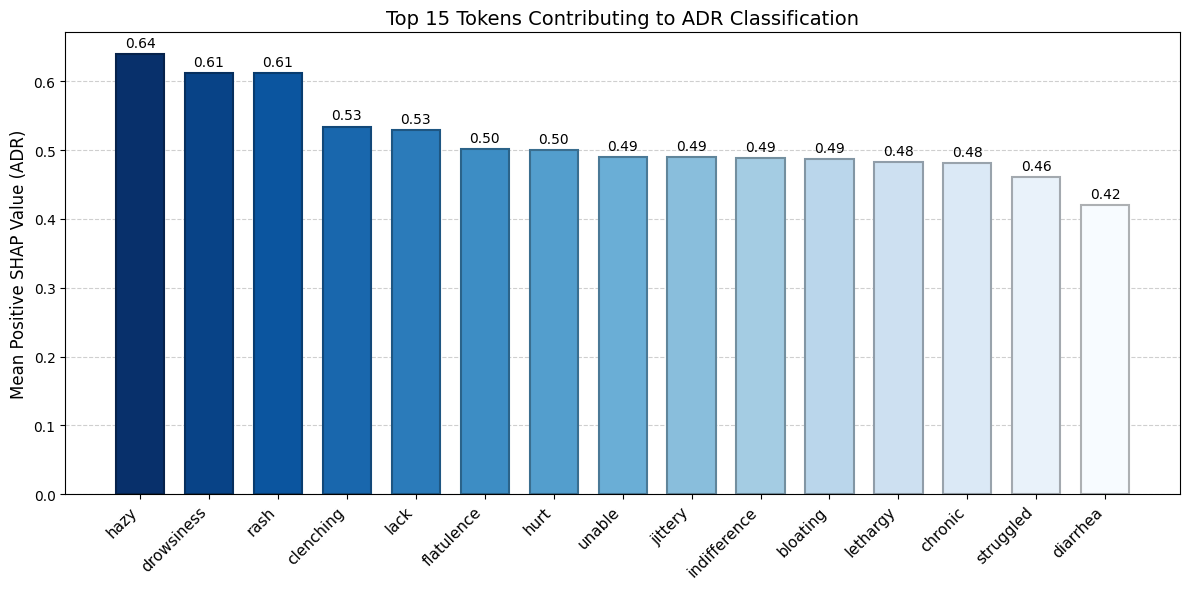

✅ Bar chart successfully saved to /content/drive/My Drive/adr_top15_barchart.pdf


In [ ]:
# Barplot for TOP 15 Token weighing to ADR Classifcation

# Load Packages
import re
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

# Function to darken a color
def darken_color(color, factor=0.7):
    """Darken the input color by the given factor."""
    rgba = to_rgba(color)  # Convert the color to RGBA format
    rgba = (rgba[0] * factor, rgba[1] * factor, rgba[2] * factor, rgba[3])
    return rgba

# Slice out the ADR (class 1) SHAP attributions
expl_adr = shap_values[..., 1]
token_lists = expl_adr.data

# Aggregate only positive ADR attributions per token
token2vals = defaultdict(list)
for sample_vals, toks in zip(expl_adr.values, token_lists):
    for v, t in zip(sample_vals, toks):
        if v <= 0 or not re.match(r"^[A-Za-z]+$", t):
            continue
        token2vals[t].append(v)

# Compute mean positive SHAP and take top 15 tokens
mean_pos = {tok: np.mean(vals) for tok, vals in token2vals.items()}
top15 = sorted(mean_pos.items(), key=lambda item: item[1], reverse=True)[:15]
tokens, scores = zip(*top15)

# Create a styled bar chart with pastel blue gradient
fig, ax = plt.subplots(figsize=(12, 6))

# Apply the reversed Blues colormap
colors = plt.cm.Blues(np.linspace(1, 0, len(tokens)))

# Darken the color for the edges
darkened_colors = [darken_color(color) for color in colors]

# Plot bars with the gradient and darker outline
bars = ax.bar(tokens, scores, color=colors, edgecolor=darkened_colors, linewidth=1.5, width=0.7)

# Add gridlines and formatting
ax.yaxis.grid(True, linestyle='--', alpha=0.6)
ax.set_axisbelow(True)

# Format x ticks
ax.set_xticks(range(len(tokens)))
ax.set_xticklabels(tokens, rotation=45, ha='right', fontsize=11)

# Set labels and title
ax.set_ylabel('Mean Positive SHAP Value (ADR)', fontsize=12)
ax.set_title('Top 15 Tokens Contributing to ADR Classification', fontsize=14)

# Annotate values on top of bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=10)

fig.tight_layout()

# 5) Save and show the plot
output_path = "/content/drive/My Drive/adr_top15_barchart.pdf"
fig.savefig(output_path, format='pdf', bbox_inches='tight')
plt.show()

print(f"✅ Bar chart successfully saved to {output_path}")


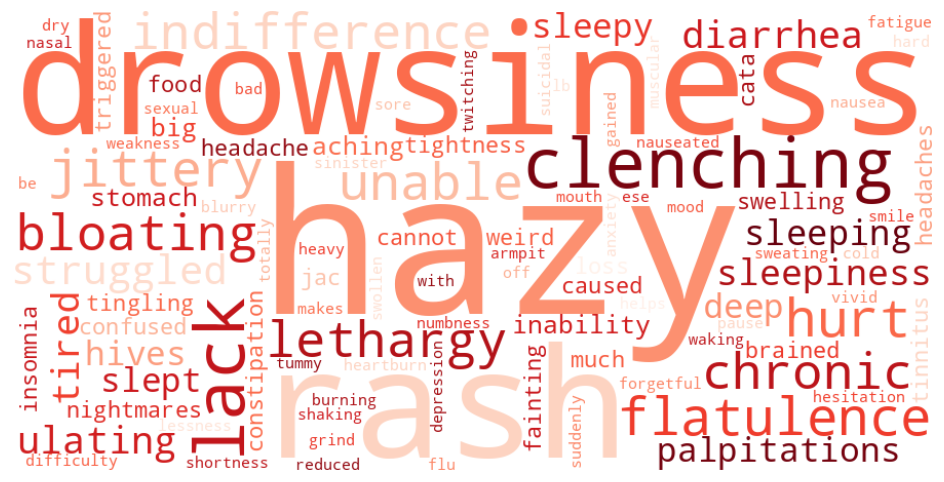

In [ ]:
# Wordcloud for TOP 15 Token weighing to ADR Classifcation

# Load Packages
from wordcloud import WordCloud
import matplotlib.pyplot as plt


# Generate and save the word cloud
top100 = sorted(mean_pos.items(), key=lambda kv: kv[1], reverse=True)[:100]
top100_dict = dict(top100)


wordcloud = WordCloud(width=900, height=450, background_color='white', colormap='Reds_r') \
    .generate_from_frequencies(top100_dict)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

output_path = "/content/drive/My Drive/adr_to100_dict_wordcloud.pdf"
plt.savefig(output_path, format='pdf', bbox_inches='tight')
plt.show()



